In [1]:
import bcolz 
import numpy as np

from sklearn.model_selection import train_test_split

import keras
from keras import backend as K 
from keras import optimizers

from keras.models import Model
from keras.layers.normalization import BatchNormalization
from keras.layers import Dense, Dropout, Flatten, Activation
from keras.applications.resnet50 import ResNet50, preprocess_input

from tensorflow.python.client import device_lib
device_lib.list_local_devices(), 'keras version: {}'.format(keras.__version__)

Using TensorFlow backend.


([name: "/cpu:0"
  device_type: "CPU"
  memory_limit: 268435456
  locality {
  }
  incarnation: 2235956572843797933, name: "/gpu:0"
  device_type: "GPU"
  memory_limit: 11332668621
  locality {
    bus_id: 2
  }
  incarnation: 14627049163866460070
  physical_device_desc: "device: 0, name: Tesla K80, pci bus id: 0000:84:00.0"],
 'keras version: 2.0.6')

In [2]:
def load_array(fname):
    return bcolz.open(fname)[:]

def freeze_model(model):
    for layer in model.layers:
        layer.trainable = False
    return model

def dense_block_none(units, activation, drop_prob, inputs):
    x = Dense(units, activation=None)(inputs)
    x = Activation(activation)(x)
    x = Dropout(drop_prob)(x)
    return x

def dense_block_one(units, activation, drop_prob, inputs):
    x = Dense(units, activation=None)(inputs)
    x = BatchNormalization()(x)
    x = Activation(activation)(x)
    x = Dropout(drop_prob)(x)
    return x

def dense_block_two(units, activation, drop_prob, inputs):
    x = BatchNormalization()(inputs)
    x = Dense(units, activation=None)(x)
    x = Activation(activation)(x)
    x = Dropout(drop_prob)(x)
    return x

In [3]:
lr = 1e-5
img_width, img_height = 224, 224
adm = optimizers.Adam(lr, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
img_out_crowd = '/beegfs/work/smapp/playground/google_images/bcolz/' \
                'crowd_img_{}x{}_2017-08-10.bc'.format(img_width, img_height)

img_out_noise = '/beegfs/work/smapp/playground/google_images/bcolz/' \
                'noise_img_{}x{}_2017-08-10.bc'.format(img_width, img_height)

In [4]:
img_crowd = load_array(img_out_crowd)
label_crowd = np.ones(len(img_crowd))
img_noise = load_array(img_out_noise)
label_noise = np.zeros(len(img_noise))

x_train = np.vstack([img_crowd, img_noise])
y_train = np.concatenate([label_crowd, label_noise])

x_train = preprocess_input(x_train.astype(np.float32))

In [5]:
x_train, x_valid, y_train, y_valid = train_test_split(x_train, y_train, test_size=0.2)
x_train.shape, y_train.shape, x_valid.shape, y_valid.shape

((2416, 224, 224, 3), (2416,), (604, 224, 224, 3), (604,))

In [6]:
# batchnorm before activation
base_model = ResNet50(input_shape=(224,224,3), 
                      weights='imagenet', 
                      include_top=False)
base_model = freeze_model(base_model)
inputs=base_model.input
m = Flatten()(base_model.layers[-1].output)
m = dense_block_none(512, 'relu', 0, inputs=m)
m = Dense(1)(m)
outputs = Activation('sigmoid')(m)

model_none = Model(inputs=inputs, outputs=outputs)
model_none.compile(loss='binary_crossentropy', 
                  optimizer=adm, 
                  metrics=['binary_crossentropy'])

In [7]:
hist0 = model_none.fit(x=x_train, 
              y=y_train, 
              batch_size=32, 
              epochs=10, 
              validation_data=(x_valid, y_valid))

Train on 2416 samples, validate on 604 samples
Epoch 1/10
2416/2416 [==============================] - 32s - loss: 0.5093 - binary_crossentropy: 0.5093 - val_loss: 0.4257 - val_binary_crossentropy: 0.4257

In [8]:
# batchnorm before activation
base_model = ResNet50(input_shape=(224,224,3), 
                      weights='imagenet', 
                      include_top=False)
base_model = freeze_model(base_model)
inputs=base_model.input
m = Flatten()(base_model.layers[-1].output)
m = dense_block_one(512, 'relu', 0, inputs=m)
m = Dense(1)(m)
outputs = Activation('sigmoid')(m)

model_one = Model(inputs=inputs, outputs=outputs)
model_one.compile(loss='binary_crossentropy', 
                  optimizer=adm, 
                  metrics=['binary_crossentropy'])

In [9]:
hist1 = model_one.fit(x=x_train, 
              y=y_train, 
              batch_size=32, 
              epochs=10, 
              validation_data=(x_valid, y_valid))

Train on 2416 samples, validate on 604 samples
Epoch 1/10
2416/2416 [==============================] - 31s - loss: 0.5306 - binary_crossentropy: 0.5306 - val_loss: 0.1959 - val_binary_crossentropy: 0.1959

In [10]:
# batchnorm before dense
base_model = ResNet50(input_shape=(224,224,3), 
                      weights='imagenet', 
                      include_top=False)
base_model = freeze_model(base_model)
inputs=base_model.input
m = Flatten()(base_model.layers[-1].output)
m = dense_block_two(512, 'relu', 0, inputs=m)
m = Dense(1)(m)
outputs = Activation('sigmoid')(m)

model_two = Model(inputs=inputs, outputs=outputs)
model_two.compile(loss='binary_crossentropy',
                  optimizer=adm)

In [11]:
hist2 = model_two.fit(x=x_train, 
              y=y_train, 
              batch_size=32, 
              epochs=10, 
              validation_data=(x_valid, y_valid))

Train on 2416 samples, validate on 604 samples
Epoch 1/10
2416/2416 [==============================] - 31s - loss: 0.2903 - val_loss: 0.2826

In [12]:
%matplotlib inline
import matplotlib.pyplot as plt

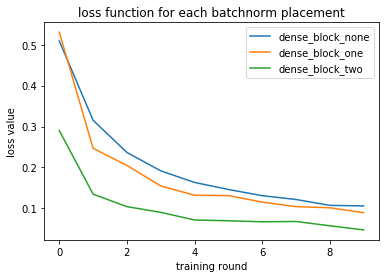

In [13]:
x = [x for x in range(len(hist0.history['binary_crossentropy']))]
plt.plot(x, hist0.history['loss'], label='dense_block_none')
plt.plot(x, hist1.history['loss'], label='dense_block_one')
plt.plot(x, hist2.history['loss'], label='dense_block_two')
plt.title('loss function for each batchnorm placement')
plt.xlabel('training round')
plt.ylabel('loss value')
plt.legend(loc='upper right')
plt.show()                                          

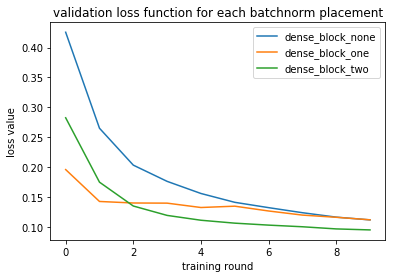

In [14]:
x = [x for x in range(len(hist0.history['binary_crossentropy']))]
plt.plot(x, hist0.history['val_loss'], label='dense_block_none')
plt.plot(x, hist1.history['val_loss'], label='dense_block_one')
plt.plot(x, hist2.history['val_loss'], label='dense_block_two')
plt.title('validation loss function for each batchnorm placement')
plt.xlabel('training round')
plt.ylabel('loss value')
plt.legend(loc='upper right')
plt.show()

As you can see for training the green batchnorm (before the dense layer) is clearly superior. It is important, however, that you run your own experiments and test things on your own for your specific problem.